In [1]:
import os

from collections import defaultdict
from pprint import pprint

import torch
import numpy as np
import seaborn as sns
from torch.utils.data import DataLoader
from pandas import DataFrame

import matplotlib.pyplot as plt

from nupic.research.frameworks.pytorch.model_utils import count_nonzero_params
from nupic.research.frameworks.pytorch.restore_utils import load_state_from_checkpoint

## Overview
This notebook calculate 
* How often each unit is on, averages accross the whole datset
* The level of sparsity seen for each output to a layer
* The entropy of each unit $$-\sum p_i \log p_i $$ where $p_i$ is the fraction of times the unit is on throughout the whole dataset.

## Load the experiment

This will load the desired experiment config and related Dataloader.

In [3]:
BATCH_SIZE = 16
PROJECT_DIR = os.path.expanduser("~/nta/nupic.research/projects/gsc")
EXPERIMENT_NAME = "default_sparse_cnn"
CHECKPOINT_FILE = "/home/ec2-user/nta/results/experiments/gsc/default_sparse_cnn/RemoteProcessTrainable_0_2021-01-07_15-54-473wnu2slv/checkpoint_30/checkpoint"
USE_CUDA = torch.cuda.is_available()

# Load the experiment
import os
import sys

sys.path.insert(0, PROJECT_DIR)

from experiments import CONFIGS

config = CONFIGS[EXPERIMENT_NAME]
exp_cls = config["experiment_class"]
exp = exp_cls()

# Load dataloader with specified BATCH_SIZE.
dataset = exp_cls.load_dataset(config, train=True)
train_loader = DataLoader(
    dataset=dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,
    sampler=None,
    pin_memory=USE_CUDA,
    drop_last=config.get("train_loader_drop_last", False),
)

## The the model from a checkpoint.

In [5]:
# Path to checkpoint.
assert CHECKPOINT_FILE is not None, "You should specify a path to a checkpoint."

# Load model
config = CONFIGS[EXPERIMENT_NAME]
exp_cls = config["experiment_class"]
exp = exp_cls()

model = exp_cls.create_model(config, "cuda")
load_state_from_checkpoint(model=model, checkpoint_path=CHECKPOINT_FILE, device="cuda");


## Helper class and method.

In [7]:
class SaveForwardOutput:
    """
    Forward hook for atorch.nn.Module. This will store the output from a module during the forward pass.

    :param name: name of the module (e.g. "classifier")
    :param verbose: whether to print something every forward pass
    """

    def __init__(self, name=None, verbose=False):
        self.name = name
        self.verbose = verbose
        self.output = None
    
    def __call__(self, module, x, y):
        """
        Forward hook on torch.nn.Module

        :param module: module
        :param x: tuple of inputs
        :param y: ouput of module
        """
        if self.verbose:
            print(f"Forward hook of {self.name} ({module.__class__.__name__})")

        # Save the output of the layer.
        self.output = y

def calculate_on_counts(rep):
    """
    Calculates the number of times a unit is on for the given batch.

    :param rep: tensor of an intermediate representation
    :return: a 1D tensor of with len equal to the total number of units
    """
    rep = rep.flatten(start_dim=1)
    on_mask = rep != 0
    on_counts = on_mask.sum(axis=0)
    return on_counts

def calculate_sparsities(rep):
    """
    Calculates the fraction of units off for each sample in the batch.

    :param rep: tensor of an intermediate representation
    :return: tensor of sparsities, one for each sample in the batch
    """
    rep = rep.flatten(start_dim=1)
    off_mask = rep == 0
    sparsities = off_mask.sum(axis=1).float()
    sparsities = sparsities / rep.shape[1]
    return sparsities


## Add forward hooks to all layers of the model

In [9]:
forward_hooks = {}
tracked_modules = []

for n, m in model.named_modules():

    # Skip over modules that have sub-modules.
    # These sub-modules will be found recursively by 'named_modules'. 
    if len(list(m.children())) > 0:
        continue

    # TODO: We can filter which modules get tracked if needed.
    forward_hook = SaveForwardOutput(name=n)
    m.register_forward_hook(forward_hook)
    forward_hooks[n] = forward_hook
    tracked_modules.append(m)

## A Brief Overview of the Model

In [11]:
total_params, on_params = count_nonzero_params(model)
print(f"Model density (on_params / total_params): {on_params:,} / {total_params:,} = {on_params/total_params:.2f}")

Model density (on_params / total_params): 194,388 / 1,717,140 = 0.11


In [13]:
print(model)

GSCSparseCNN(
  (cnn1): SparseWeights2d(
    sparsity=0.5
    (module): Conv2d(1, 64, kernel_size=(5, 5), stride=(1, 1))
  )
  (cnn1_batchnorm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
  (cnn1_kwinner): KWinners2d(channels=64, local=False, break_ties=False, n=0, percent_on=0.095, boost_strength=0.06358673423528671, boost_strength_factor=0.9, k_inference_factor=1.0, duty_cycle_period=1000)
  (cnn1_maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn2): SparseWeights2d(
    sparsity=0.8
    (module): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1))
  )
  (cnn2_batchnorm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
  (cnn2_kwinner): KWinners2d(channels=64, local=False, break_ties=False, n=0, percent_on=0.125, boost_strength=0.06358673423528671, boost_strength_factor=0.9, k_inference_factor=1.0, duty_cycle_period=1000)
  (cnn2_maxpool): MaxPool2d(kernel_size=2, stride=2, p

## Compute statistics of the output representations
* How often each unit is on
* The level of sparsity for each output from a layer

In [24]:
# This will be a tensor of length equal to the total number of output units to the given layer.
# Each value will represent the frequency ("freq") of how often that unit is on throughout the whol dataset.
layer_on_freqs = defaultdict(int)

# This will be a list of sparsities measure for each output passed to the layer.
layer_sparsities = defaultdict(list)

# Loop through the whole dataset. See "Load the experiment" section
# above to use the validation dataloader if desired.
total_images = 0
model.eval()
for x, y in train_loader:
    x, y = x.to("cuda"), y.to("cuda")
    out = model(x)

    for name, hook in forward_hooks.items():

        # Retrieve ouput saved in the forward hook.
        representation = hook.output

        # Tally the on-counts for each unit.
        on_counts = calculate_on_counts(representation)
        layer_on_freqs[name] += on_counts

        # Compute the level of sparsity for each output.
        sparsities = calculate_sparsities(representation)
        layer_sparsities[name].extend(sparsities.tolist())

    total_images += len(x)

# Divide through by number of samples to find on-frequency for eash unit.
for layer, on_counts in layer_on_freqs.items():
    layer_on_freqs[layer] = on_counts.float() / total_images


## Print summary of statitics
* How often each unit is on
* The level of sparsity for each output to a layer
* The entropy of each unit (excluding dead units; otherwise we take the lof of zero)

In [25]:
df = DataFrame(columns=["module type", "mu output sparsity", "sd output sparsity", "entropy", "dead neuron count", "total neurons", "fraction_dead"])


def log2_of_zeros(arr):
    """
    Intentionally leave zero's as they are when taking the log.
    """
    arr = arr.copy()
    arr[arr != 0] = np.log(arr[arr != 0])
    return arr


for (layer, sparsities), freqs, module in zip(layer_sparsities.items(), layer_on_freqs.values(), tracked_modules):

    mu_sparsity = np.mean(sparsities)
    sd_sparsity = np.std(sparsities)
    module_type = module.__class__.__name__
    print(f"Layer {layer} ({module_type})")
    print(f"    Average sparsity of output = {mu_sparsity:.3f} ± {sd_sparsity:.3f}")

    freqs = freqs.cpu().numpy()
    entropy = np.sum(-freqs * log2_of_zeros(freqs) / len(freqs))
    print(f"    Entropy of layer = {entropy}")

    dead_count = (freqs == 0).sum()
    total_neurons = len(freqs)
    fraction_dead = dead_count / total_neurons
    print(f"    Fractions of dead neurons in layer = {fraction_dead:.3f} ({dead_count} out of {total_neurons})")
    print()

    df.at[layer] = (module_type, mu_sparsity, sd_sparsity, entropy, dead_count, total_neurons, fraction_dead)



Layer cnn1.module (Conv2d)
    Average sparsity of output = 0.000 ± 0.000
    Entropy of layer = 0.0
    Fractions of dead neurons in layer = 0.000 (0 out of 50176)

Layer cnn1_batchnorm (BatchNorm2d)
    Average sparsity of output = 0.000 ± 0.000
    Entropy of layer = 4.280653698174319e-08
    Fractions of dead neurons in layer = 0.000 (0 out of 50176)

Layer cnn1_kwinner (KWinners2d)
    Average sparsity of output = 0.903 ± 0.004
    Entropy of layer = 0.19471943378448486
    Fractions of dead neurons in layer = 0.000 (0 out of 50176)

Layer cnn1_maxpool (MaxPool2d)
    Average sparsity of output = 0.851 ± 0.016
    Entropy of layer = 0.24615955352783203
    Fractions of dead neurons in layer = 0.000 (0 out of 12544)

Layer cnn2.module (Conv2d)
    Average sparsity of output = 0.000 ± 0.000
    Entropy of layer = 0.0
    Fractions of dead neurons in layer = 0.000 (0 out of 6400)

Layer cnn2_batchnorm (BatchNorm2d)
    Average sparsity of output = 0.000 ± 0.000
    Entropy of layer =

In [26]:
df

,module type,mu output sparsity,sd output sparsity,entropy,dead neuron count,total neurons,fraction_dead
cnn1.module,Conv2d,0,0,0,0,50176,0
cnn1_batchnorm,BatchNorm2d,4.28138e-08,9.22735e-07,4.28065e-08,0,50176,0
cnn1_kwinner,KWinners2d,0.903458,0.00412662,0.194719,0,50176,0
cnn1_maxpool,MaxPool2d,0.851052,0.0163166,0.24616,0,12544,0
cnn2.module,Conv2d,0,0,0,0,6400,0
cnn2_batchnorm,BatchNorm2d,2.28859e-08,1.89087e-06,2.2882e-08,0,6400,0
cnn2_kwinner,KWinners2d,0.874997,4.19071e-05,0.246587,0,6400,0
cnn2_maxpool,MaxPool2d,0.749466,0.0423709,0.329674,0,1600,0
flatten,Flatten,0.749466,0.0423709,0.329674,0,1600,0
linear.module,Linear,0,0,0,0,1000,0


## Visualize the distribution of how often each unit is on or off


In [27]:
print("Names of layers observed via hooks: (helpful for specifying 'layer' in the cell below.\n")
pprint(list(layer_on_freqs.keys()))

Names of layers observed via hooks: (helpful for specifying 'layer' in the cell below.

['cnn1.module',
 'cnn1_batchnorm',
 'cnn1_kwinner',
 'cnn1_maxpool',
 'cnn2.module',
 'cnn2_batchnorm',
 'cnn2_kwinner',
 'cnn2_maxpool',
 'flatten',
 'linear.module',
 'linear_bn',
 'linear_kwinner',
 'output',
 'softmax']


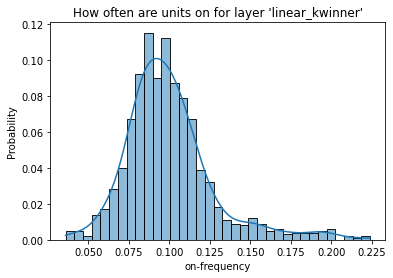

In [28]:
# Choose one layer to visualize the frequency of it's output units being on or off.
layer = "linear_kwinner"

on_freqs = layer_on_freqs[layer].cpu().numpy()

fig = sns.histplot(data=on_freqs, kde=True, stat="probability")
fig.set_xlabel("on-frequency")
fig.set_title(f"How often are units on for layer '{layer}'");